## Script to compute FID between original CMR and reconstructed CMR

In [1]:
# https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/

import numpy
import pandas as pd
import glob
from os.path import exists as file_exists
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
import SimpleITK as sitk
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from dataloader.class_transformations import TransformationGenerator
import utils.io.image

In [2]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [3]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(320,256,3))

In [4]:
# Generator for original images
pad_input = TransformationGenerator(output_size=(128, 128, 15),
                                     output_spacing=[1, 1, 1],
                                     training=False,
                                     pixel_margin_ratio = 0.3,
                                     normalize = 0)

ids_set = pd.read_csv('./input_data/ids/automatic_LVM_LVEDV_mtdt_reduced.csv', sep=',') 


In [5]:
# Checking all the reconstructed image match the original images in number
recons_list = [i.split('/')[-1].split('.')[-2].split('_')[-1] for i in glob.glob('./gen_data/*')]
ids_set = ids_set[ids_set.ID.isin(recons_list)]

In [6]:
print(ids_set.shape)

(5648, 57)


In [7]:
# FID batch
batch_fid = 4

fids = []
for j in range(500):
    
    batch_orig_sax = []
    batch_recons_sax = []

    for ID in ids_set[j*batch_fid:(j+1)*batch_fid].values:
                
        path_orig_sax = './input_data/' + 'sax/' + str(int(ID[0])) + '/' + 'image_SAX_001.vtk'

        orig_sax = pad_input.get(path_orig_sax,
                            int(ID[1]),
                            int(ID[2]),
                            int(ID[3]),
                            int(ID[4]),
                            int(ID[5])
                           )
        orig_sax = orig_sax.swapaxes(0, 2) 

        recons_sax = sitk.GetArrayFromImage(utils.io.image.read('./gen_data/reconstructed_' + str(int(ID[0])) + '.vtk'))   
        recons_sax = recons_sax.swapaxes(0, 2)

        orig_sax = numpy.reshape(orig_sax, (320,256,3))
        recons_sax = numpy.reshape(recons_sax, (320,256,3))

        # pre-process images
        orig_sax = preprocess_input(orig_sax)
        recons_sax = preprocess_input(recons_sax)

        batch_orig_sax.append(orig_sax)
        batch_recons_sax.append(recons_sax)

    # fid between orig_sax and recons_sax
    fid = calculate_fid(model, numpy.array(batch_orig_sax, dtype='float32'), numpy.array(batch_recons_sax, dtype='float32'))
    print('FID: %.3f' % fid)
    fids.append(fid)
    
fids = numpy.array(fids)

FID: 8.211
FID: 8.288
FID: 7.478
FID: 8.162
FID: 8.229
FID: 8.954
FID: 8.584
FID: 8.656
FID: 8.039
FID: 9.665
FID: 8.998
FID: 8.078
FID: 8.280
FID: 9.441
FID: 8.845
FID: 7.598
FID: 9.376
FID: 7.998
FID: 8.688
FID: 8.822
FID: 9.645
FID: 8.087
FID: 10.018
FID: 8.853
FID: 9.799
FID: 9.271
FID: 8.215
FID: 8.931
FID: 8.425
FID: 7.627
FID: 8.514
FID: 8.826
FID: 9.458
FID: 7.112
FID: 10.308
FID: 9.951
FID: 8.807
FID: 9.521
FID: 8.746
FID: 7.410
FID: 9.003
FID: 6.975
FID: 7.816
FID: 8.189
FID: 8.793
FID: 8.610
FID: 8.635
FID: 8.681
FID: 7.939
FID: 9.083
FID: 7.577
FID: 8.394
FID: 8.191
FID: 9.303
FID: 8.962
FID: 8.672
FID: 8.106
FID: 8.850
FID: 8.770
FID: 8.256
FID: 9.708
FID: 8.011
FID: 9.113
FID: 8.947
FID: 7.301
FID: 7.776
FID: 6.588
FID: 6.226
FID: 7.675
FID: 8.945
FID: 9.760
FID: 8.577
FID: 8.746
FID: 8.293
FID: 9.644
FID: 9.991
FID: 7.037
FID: 7.971
FID: 8.139
FID: 8.524
FID: 9.103
FID: 7.152
FID: 8.681
FID: 8.835
FID: 8.311
FID: 7.900
FID: 7.770
FID: 7.876
FID: 8.698
FID: 8.691
FID: 6.6

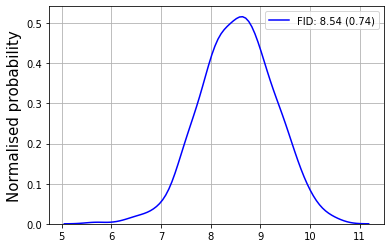

<Figure size 432x288 with 0 Axes>

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.distplot(fids, 
                  color="blue", 
                  hist=False, 
                  label=f'FID: {str(round(fids.mean(), 2))} ({str(round(fids.std(), 2))})'
                 )
plt.legend(loc="upper right") 
ax.set_ylabel('Normalised probability', fontsize=15)
ax.grid(True)
plt.savefig("dis_FID.pdf", bbox_inches='tight')
plt.savefig("dis_FID.png", bbox_inches='tight')
plt.show()
plt.clf()